# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("datasetClassifier") \
                    .getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 10660


,structureChainId,alpha,beta,coil,foldType,features
0,1RXQ.D,0.662722,0.065089,0.272189,alpha+beta,"[0.03355525744721125, 0.2672737870460092, 0.44..."
1,1RYL.B,0.550336,0.154362,0.295302,alpha+beta,"[-0.03064694956326521, -0.019814661751692015, ..."
2,1RYO.A,0.367284,0.212963,0.419753,alpha+beta,"[0.13665451809901036, 0.06933704541390476, 0.3..."
3,1RYP.E,0.351240,0.260331,0.388430,alpha+beta,"[-0.19166820620754696, -0.035750856561223, 0.3..."
4,1RYP.N,0.321888,0.313305,0.364807,alpha+beta,"[0.12672561553009817, 0.018070112488328897, 0...."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 2584


,structureChainId,alpha,beta,coil,foldType,features
7,1RZ4.A,0.676056,0.028169,0.295775,alpha,"[-0.08727558182345496, 0.07827300824017988, 0...."
8,1RZH.L,0.619217,0.035587,0.345196,alpha,"[-0.034122437554677684, -0.08903528297419792, ..."
9,1RZH.M,0.634551,0.039867,0.325581,alpha,"[-0.141879534431021, 0.019542623172800234, 0.5..."
11,1S0P.B,0.755682,0.011364,0.232955,alpha,"[0.31434613252324717, 0.04741660307294556, 0.3..."
16,1S2X.A,0.772222,0.000000,0.227778,alpha,"[0.2737482454332455, 0.09691677558712843, -0.0..."


## Set features to be list of float instead of string 

In [5]:
df.features = df.features.apply(lambda x: np.array(list(x), dtype=np.float))

## Basic dataset information and setting

In [6]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 2584
alpha    1924
beta      660
Name: foldType, dtype: int64

Dataset size (balanced)  : 1320
alpha    660
beta     660
Name: foldType, dtype: int64


## Decision Tree Classifier


 Class	Train	Test

alpha	588	72

beta	600	60

 Total time taken: 0.060487985610961914
Methods	DecisionTreeClassifier
AUC	0.8333333333333334
F Score	0.8270676691729323
Accuracy	0.8257575757575758
Precision	0.7534246575342466
Recall	0.9166666666666666
False Positive Rate	0.2465753424657534
True Positive Rate	0.9152542372881356
	
Confusion Matrix
['alpha' 'beta']
[[54 18]
 [ 5 55]]


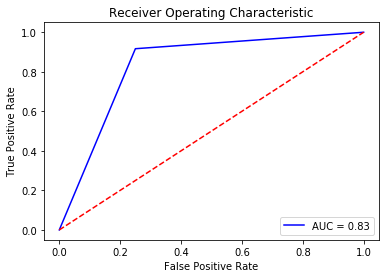

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,2176,4D7C.B,0.044898,0.559184,0.395918,beta,"[0.2234585819943008, 0.2321626300297179, 0.336...",1,beta
1,1690,2DPF.D,0.000000,0.441441,0.558559,beta,"[-0.07219405693671943, 0.21463602097508938, 0....",1,beta
2,9979,4ZV5.B,0.714286,0.000000,0.285714,alpha,"[0.04074326144117448, 0.03463577093660004, 0.3...",0,alpha
3,5468,4NSX.A,0.004732,0.522082,0.473186,beta,"[0.27874243397492027, 0.12074878577505666, 0.2...",1,beta
4,6988,1KLX.A,0.706767,0.000000,0.293233,alpha,"[0.11067472144036831, -0.17067403172271964, 0....",0,beta


In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head()

## Random Forest Classifier


 Class	Train	Test

alpha	592	68

beta	596	64

 Total time taken: 0.06425738334655762
Methods	RandomForestClassifier
AUC	0.9246323529411764
F Score	0.84375
Accuracy	0.8484848484848485
Precision	0.84375
Recall	0.84375
False Positive Rate	0.15625
True Positive Rate	0.8529411764705882
	
Confusion Matrix
['alpha' 'beta']
[[58 10]
 [10 54]]


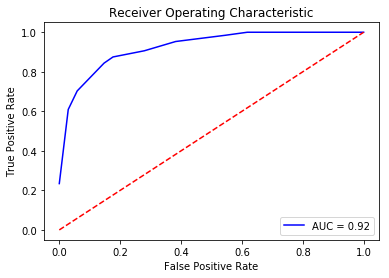

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,10489,5ANR.C,0.173913,0.000000,0.826087,alpha,"[0.17407351084659958, 0.40180246202751646, 0.3...",0,beta
1,1053,2CO3.A,0.029630,0.548148,0.422222,beta,"[0.2829009999815539, 0.15190362952211323, 0.36...",1,beta
2,9504,2Q24.B,0.777143,0.000000,0.222857,alpha,"[-0.3456635875892801, -0.1096354041277513, 0.4...",0,alpha
3,1594,1Z67.A,0.700787,0.000000,0.299213,alpha,"[-0.2669481519720892, -0.17275583428511423, 0....",0,alpha
4,1294,4X2C.B,0.660098,0.039409,0.300493,alpha,"[0.2620500579961918, 0.18894920173761812, 0.11...",0,alpha
5,7222,1UPS.A,0.049751,0.415423,0.534826,beta,"[0.3059836349723447, 0.22529972898429326, 0.28...",1,beta
6,8684,4BFO.A,0.028302,0.537736,0.433962,beta,"[0.4678057109848375, 0.2935785559139082, 0.062...",1,beta
7,10015,4RUQ.B,0.016878,0.531646,0.451477,beta,"[0.17886718574376925, 0.0745146136990265, 0.14...",1,beta
8,6970,1FCY.A,0.677966,0.042373,0.279661,alpha,"[0.0503898909533436, -0.05310073146953228, 0.2...",0,alpha
9,6942,1XWV.B,0.023256,0.534884,0.441860,beta,"[0.21754074178170413, -0.21471593373280484, 0....",1,beta


In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	607	53

beta	581	79

 Total time taken: 0.023184537887573242
Methods	LogisticRegression
AUC	0.9536661093861954
F Score	0.9150326797385621
Accuracy	0.9015151515151515
Precision	0.9459459459459459
Recall	0.8860759493670886
False Positive Rate	0.05405405405405406
True Positive Rate	0.8448275862068966
	
Confusion Matrix
['alpha' 'beta']
[[49  4]
 [ 9 70]]


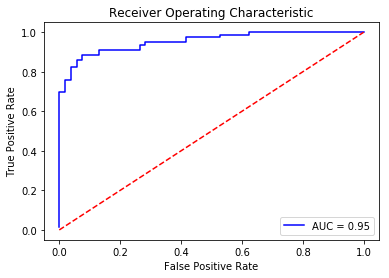

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,1539,3VVY.D,0.786885,0.010929,0.202186,alpha,"[-0.13828796083638398, -0.07408946409213497, 0...",0,alpha
1,7787,3SEE.A,0.032710,0.415888,0.551402,beta,"[0.31537068343396846, -0.0906989367012929, 0.3...",1,beta
2,3875,2JJU.A,0.028037,0.457944,0.514019,beta,"[0.04228264347664894, 0.24227175066277146, 0.4...",1,beta
3,8800,5O0U.A,0.000000,0.333333,0.666667,beta,"[-0.08264916056189044, 0.03221452107717251, -0...",1,alpha
4,2241,4JDE.B,0.020979,0.594406,0.384615,beta,"[0.2815715639177581, 0.08559827266325211, 0.55...",1,beta
5,4060,3NL9.A,0.639053,0.011834,0.349112,alpha,"[0.07878007276312393, -0.08376096600995345, 0....",0,alpha
6,4109,5OD4.A,0.024194,0.427419,0.548387,beta,"[0.11199439520118978, 0.23081684552543744, 0.4...",1,beta
7,3651,4UWX.A,0.760684,0.000000,0.239316,alpha,"[-0.13560086191326629, -0.08327121363890146, 0...",0,alpha
8,4381,3LPZ.A,0.697452,0.012739,0.289809,alpha,"[-0.2107099366666221, 0.0005848583612424224, 0...",0,alpha
9,9495,2PVB.A,0.564815,0.018519,0.416667,alpha,"[0.21706521577227894, -0.2402034447850468, 0.3...",0,alpha


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	594	66

beta	594	66

 Total time taken: 1.4907608032226562
Methods	MLPClassifier
AUC	0.9173553719008265
F Score	0.8702290076335878
Accuracy	0.8712121212121212
Precision	0.8769230769230769
Recall	0.8636363636363636
False Positive Rate	0.12307692307692308
True Positive Rate	0.8656716417910447
	
Confusion Matrix
['alpha' 'beta']
[[58  8]
 [ 9 57]]


/home/marshuang80/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


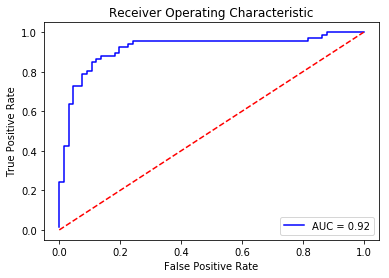

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,9376,4M5B.A,0.738318,0.028037,0.233645,alpha,"[-0.21287412304189746, -0.12988576424066667, 0...",0,alpha
1,6927,3NJN.C,0.000000,0.543860,0.456140,beta,"[0.3128334812630536, 0.042370376769074444, 0.3...",1,beta
2,7099,1MY7.B,0.029412,0.470588,0.500000,beta,"[0.1758518410450985, 0.04912052975670822, 0.33...",1,alpha
3,9477,3GLD.B,0.021429,0.539286,0.439286,beta,"[0.5885231537319923, 0.1694544999524444, 0.414...",1,beta
4,1992,4Y6W.A,0.796209,0.000000,0.203791,alpha,"[-0.5813173096435014, 0.08767937853924211, 0.5...",0,alpha
5,6773,3D33.A,0.031915,0.585106,0.382979,beta,"[0.308230450585763, 0.09601084161636846, 0.390...",1,beta
6,5101,1LGH.G,0.857143,0.000000,0.142857,alpha,"[-0.0785994928330183, -0.28728382357142185, 0....",0,beta
7,1485,2BRQ.C,0.000000,0.714286,0.285714,beta,"[0.5439648321519295, 0.4057565115392208, 0.107...",1,beta
8,9679,3EFG.A,0.901961,0.000000,0.098039,alpha,"[-0.3559593691599447, 0.11035769204790523, 0.4...",0,alpha
9,6136,2FD5.A,0.744444,0.000000,0.255556,alpha,"[-0.4051629694220324, -0.20252301668560954, 0....",0,alpha


In [10]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [11]:
spark.stop()